## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [3]:
print(X.isna().values.any())
(X.dtypes == "object").values

False


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

В наборе данных нет пропущенных значений и категориальных переменных.

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [4]:
from sklearn.model_selection import train_test_split

seed = np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

Аргумент stratify важен, потому что он сохраняет пропорции классов и позволяет модели учиться на более правильном наборе данных.

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_acc = []
test_acc = []
clfs = []

neighbors = [1, 3, 5, 10, 15, 25]
for i in neighbors:
  clf = KNeighborsClassifier(n_neighbors=i)
  clf.fit(X_train[:, 0:5:4], y_train)
  clfs.append(clf)

  y_pred1 = clf.predict(X_train[:, 0:5:4])
  train_acc.append(round(accuracy_score(y_train, y_pred1), 2))

  y_pred2 = clf.predict(X_test[:, 0:5:4])
  test_acc.append(round(accuracy_score(y_test, y_pred2), 2))

acc = pd.DataFrame({'Train': train_acc, 'Test': test_acc}, index=neighbors).rename_axis('NN', axis=1)
print(acc)

NN  Train  Test
1    1.00  0.56
3    0.80  0.63
5    0.78  0.63
10   0.75  0.65
15   0.72  0.63
25   0.69  0.69


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [8]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [9]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

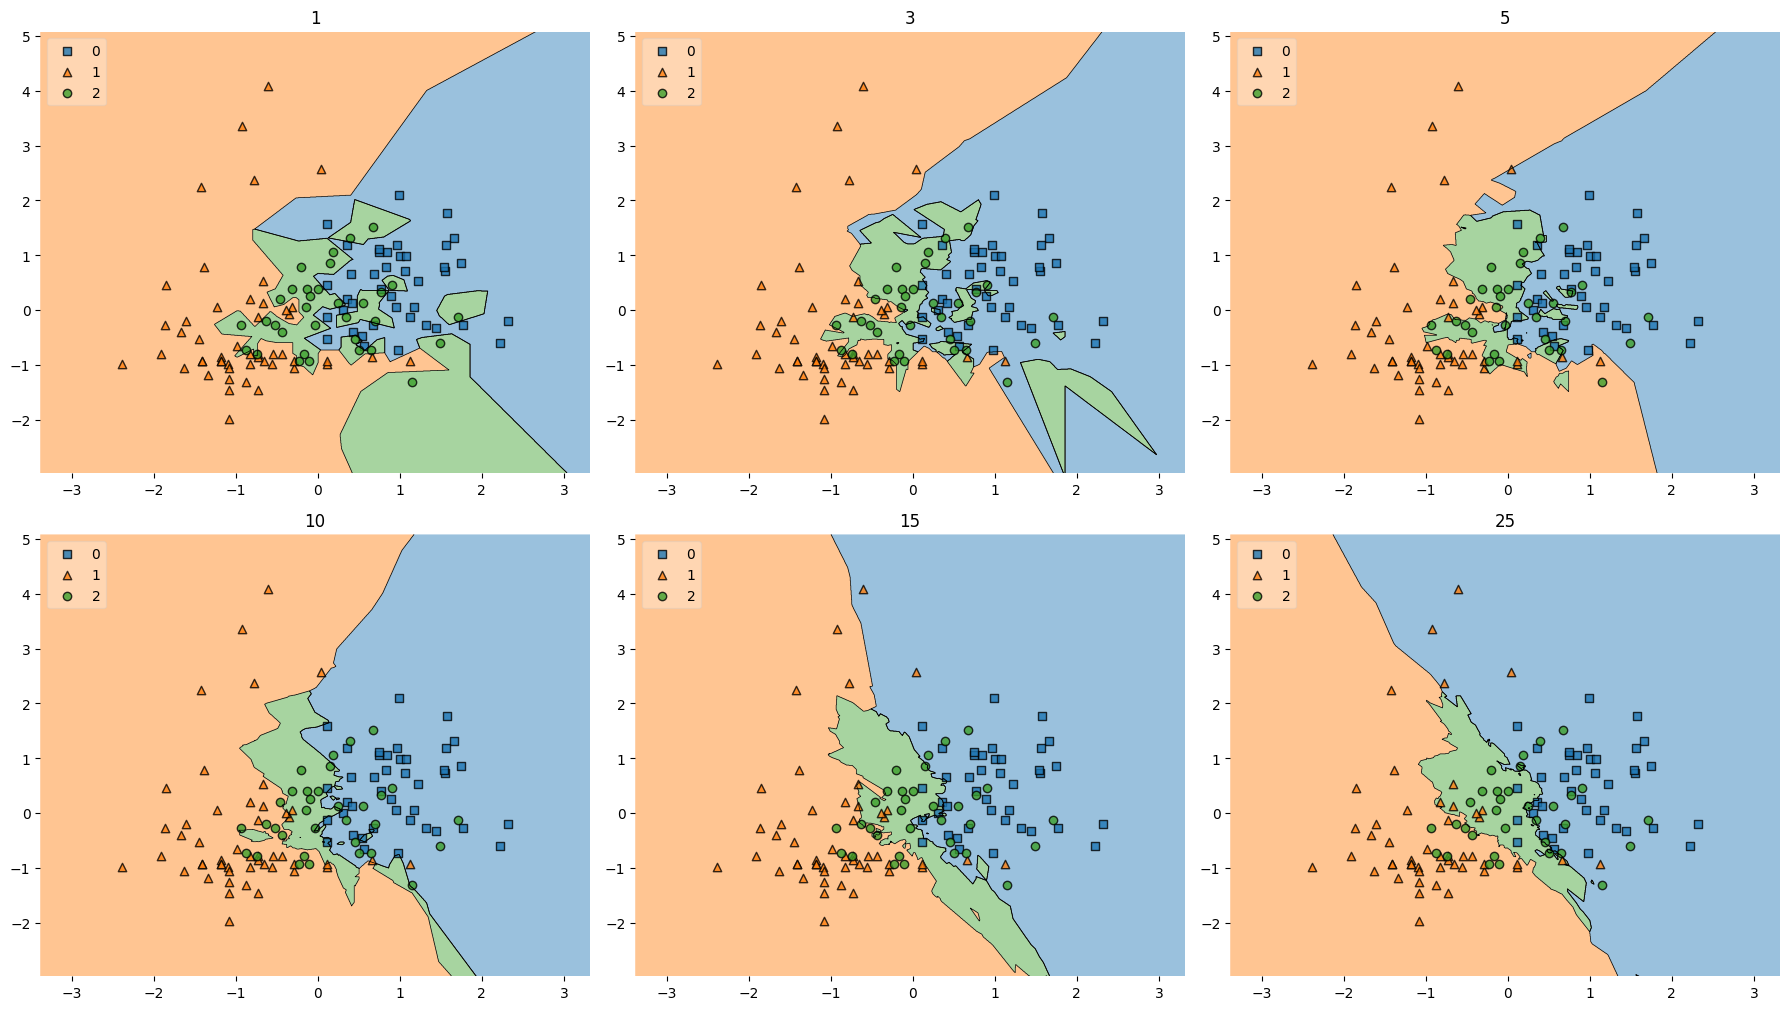

In [10]:
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions

gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(18, 15))

for i in range(6):
  plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(wspace=0.4, hspace=0.4)

  plot_decision_regions(X_train[:, 0:5:4], y_train, clf=clfs[i], legend=2)
  plt.title(neighbors[i])


plt.tight_layout()
plt.show()



**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Оптимальное число соседей = 10, поскольку при данном числе соседей максимизируется доля правильных ответов на train и на test, а также на графике все области достаточно скучкованы. Но стоит сказать, что при 15 и 25 соседях графики выглядят ещё более кучно, что конечно нам больше подходит, однако в 1.3 мы можем заметить, что при данных значениях k точность начинает снижаться.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

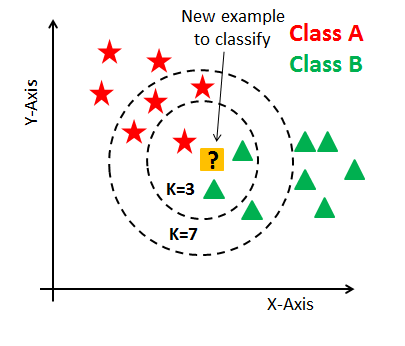

In [11]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        preds = []
        for x in X:
          dists = [self.count_distance(x, x_train) for x_train in self.X_train] #считаем евклидовое расстояние до всех элементов
          inds = np.argsort(dists)[:self.k] #находим индексы ближайших элементов и обрезаем k соседей
          knns = [self.y_train[i] for i in inds] #находим целевые переменные для этих соседей
          most_common = Counter(knns).most_common(1) #с помощью counter находим самый частый ответ
          preds.append(most_common[0][0])
        return np.array(preds)

    def count_distance(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2))

In [12]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [13]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [14]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [15]:
print(data.isna().values.any())

data = data.drop('Unnamed: 0', axis=1)

False


Первый столбец является бессмысленным, поскольку он просто содержит индексы элементов, а для доступа к индексам в датафрейме нам не нужен отдельный столбец.

**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [16]:
corr_matrix=data.corr()
print(corr_matrix["price"].sort_values(ascending=False))

price    1.000000
carat    0.921591
x        0.884435
y        0.865421
z        0.861249
table    0.127134
depth   -0.010647
Name: price, dtype: float64


<ipython-input-16-c384dfa1b8b8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=data.corr()


Наибольшая корреляция с ценой наблюдается у показателей карата и размеров бриллианта, тогда как "глубина" наоборот не оказывает особого влияния на цену.

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [17]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
ohed = ohe.fit_transform(data[['cut', 'color', 'clarity']])

data = pd.concat([data, ohed], axis=1).drop(columns=['cut', 'color', 'clarity'])

**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [18]:
y1 = data['price']
X1 = data.drop('price', axis=1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=np.random.seed(52))

Я не использовала параметр Stratify из-за того, что в связи с особенностями базы данных он выдает ошибку, поскольку есть категории по одному значению.

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [19]:
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression().fit(X1_train, y1_train)

print('MSE on train:', mean_squared_error(linreg.predict(X1_train), y1_train))
print('MSE on test:', mean_squared_error(linreg.predict(X1_test), y1_test))

MSE on train: 1283859.068354082
MSE on test: 1261612.9574434122


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [21]:
cols = data.drop('price', axis=1).columns
pd.Series(data=linreg.coef_, index=cols)

carat            5279.547975
depth             -96.275606
table             -65.808786
x               -1075.771486
y                   0.798339
z                 -28.767314
cut_Fair         -129.438353
cut_Good          -37.198281
cut_Ideal          51.340787
cut_Premium        17.059152
cut_Very Good       0.380004
color_D           206.252481
color_E           160.727894
color_F           132.361716
color_G            57.388766
color_H          -123.110176
color_I          -248.681138
color_J          -382.552207
clarity_I1       -475.971481
clarity_IF        231.215154
clarity_SI1      -147.275073
clarity_SI2      -493.721798
clarity_VS1       208.596172
clarity_VS2       110.106933
clarity_VVS1      245.534089
clarity_VVS2      282.444175
dtype: float64

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [22]:
from sklearn import linear_model
from sklearn.linear_model import Ridge

lss = linear_model.Lasso(alpha=10)
lss.fit(X1_train, y1_train)

rdg = Ridge(alpha=10)
rdg.fit(X1_train, y1_train)

#print('Lasso on train:', mean_squared_error(lss.predict(X1_train), y1_train))
#print('Lasso on test:', mean_squared_error(lss.predict(X1_test), y1_test))
#print('Ridge on train:', mean_squared_error(rdg.predict(X1_train), y1_train))
#print('Ridge on test:', mean_squared_error(rdg.predict(X1_test), y1_test))

coefs = pd.DataFrame({'Lasso': lss.coef_, 'Ridge': rdg.coef_}, index=cols)
print(coefs)

                     Lasso        Ridge
carat          4816.007210  5242.783879
depth           -62.964167   -93.709580
table           -52.121689   -65.515438
x              -619.478795 -1033.535674
y                -0.000000    -1.583045
z               -41.501098   -32.927960
cut_Fair       -130.508352  -129.609597
cut_Good        -38.463807   -37.296995
cut_Ideal        41.489457    51.339283
cut_Premium       0.000000    17.068615
cut_Very Good    -0.000000     0.509871
color_D         142.236910   205.992353
color_E          90.570636   160.519555
color_F          61.712949   131.917684
color_G          -0.000000    57.117280
color_H        -165.564424  -122.835765
color_I        -277.134043  -248.052848
color_J        -398.646938  -381.839686
clarity_I1     -493.388390  -475.443920
clarity_IF      178.257614   231.574271
clarity_SI1    -260.651166  -147.815782
clarity_SI2    -583.978115  -493.603106
clarity_VS1     101.608211   208.425305
clarity_VS2      -0.000000   109.929495


Веса уменьшились на всех признаках, особенно при использовании Lasso, что указывает на довольно значительную проблему мультиколлинеарности.

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.551e+08, tolerance: 5.990e+07
  model = cd_fast.enet_coordinate_descent(


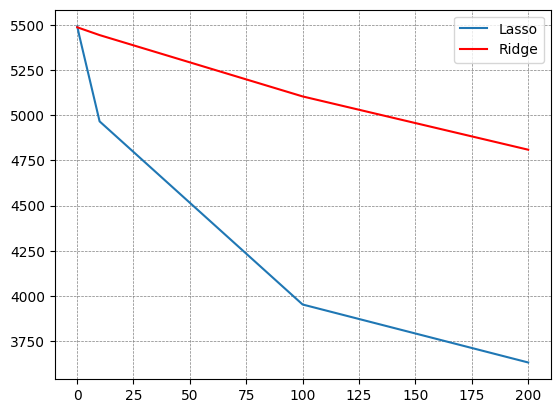

In [24]:
lss_coefs = []
rdg_coefs = []
alphas = [0.1, 1, 10, 100, 200]

for a in alphas:
  lss = linear_model.Lasso(alpha=a)
  lss.fit(X1_train, y1_train)
  lss_coefs.append(np.linalg.norm(lss.coef_))

  rdg = Ridge(alpha=a)
  rdg.fit(X1_train, y1_train)
  rdg_coefs.append(np.linalg.norm(rdg.coef_))

#print(pd.DataFrame({'Lasso': lss_coefs, 'Ridge': rdg_coefs}, index=alphas))

x = np.linspace(-3,3,100)
plt.plot(alphas, lss_coefs, label='Lasso')
plt.plot(alphas, rdg_coefs, label='Ridge', color='red')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

Чаще всего выбирают именно Lasso, потому что данная модель агрессивнее уменьшает веса в связи с тем, что Lasso может обнулять коэффициенты незначимых переменных, тогда как Ridge может только приводить их близко к 0.

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [25]:
from sklearn.linear_model import LassoCV
from statistics import mean

lsscv = LassoCV(cv=5, alphas=alphas)
lsscv.fit(X1_train, y1_train)
#print(pd.DataFrame(data=lsscv.mse_path_))

mse_alphas = []
for i in range(5):
  mse_alphas.append(mean(lsscv.mse_path_[i]))

mse_alphas

pd.Series(data=mse_alphas, index=lsscv.alphas_)

200.0    1.949104e+06
100.0    1.536606e+06
10.0     1.299103e+06
1.0      1.288418e+06
0.1      1.288419e+06
dtype: float64

Наибольшее качество дает alpha = 1.0

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [26]:
lss = linear_model.Lasso(alpha=1)
lss.fit(X1_train, y1_train)

pd.Series(data=lss.coef_, index=cols)

carat            5233.707893
depth             -92.957422
table             -64.442473
x               -1029.869511
y                  -0.000000
z                 -30.011619
cut_Fair         -135.537256
cut_Good          -47.371906
cut_Ideal          33.197992
cut_Premium         0.000000
cut_Very Good     -14.224042
color_D           158.113805
color_E           105.324141
color_F            77.369061
color_G            -0.000000
color_H          -172.827731
color_I          -289.495649
color_J          -412.153885
clarity_I1       -505.534728
clarity_IF        184.169682
clarity_SI1      -259.654204
clarity_SI2      -592.006323
clarity_VS1       113.418656
clarity_VS2        -0.000000
clarity_VVS1      179.721592
clarity_VVS2      205.009193
dtype: float64

Больше всего на цену по-прежнему влияет карат и размер, но при этом параметр "x" оказывает наибольшее влияние, тогда как "y" и "z" - практически незначительное. Также влияние оказывают определенные значения "clarity" и "color".

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [ ]:
print('MSE linreg:', mean_squared_error(linreg.predict(X1_test), y1_test))
print('MSE lasso:', mean_squared_error(lss.predict(X1_test), y1_test))

MSE linreg: 1261612.9574434122
MSE lasso: 1262491.309161884


У меня результаты получились довольно близкими, но обычная линейная регрессия почему-то оказалась немного точнее. Вообще Lasso должно минимизировать функцию ошибки засчет зануления и уменьшения коэффициентов, но возможно на данном примере Lasso слишком сильно уменьшило определенные веса и за счет этого MSE увеличилось.

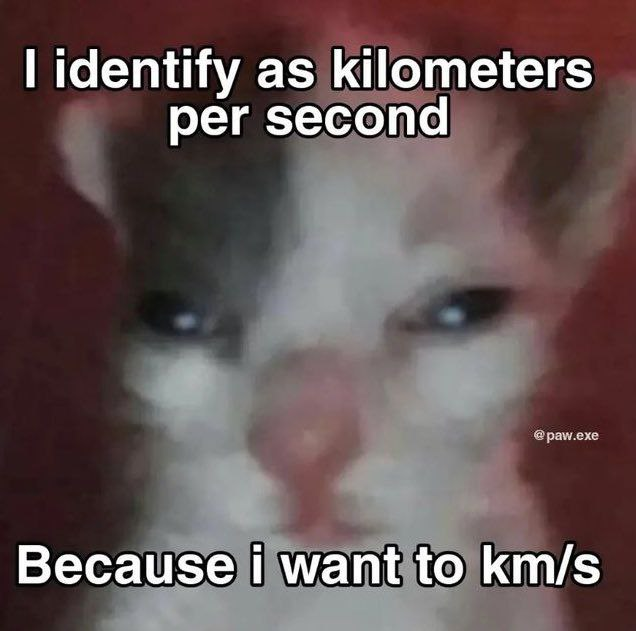